In [1]:
'''This notebook displays and analyzes basic FC and PSP data from Stasinski et al. 2024
by Jan Stasinski '''

'This notebook displays and analyzes basic FC and PSP data from Stasinski et al. 2024\nby Jan Stasinski '

In [10]:
# load libraries

import sys
sys.path.append('/Users/jansta/fic_jansen/stability_analysis')
import os

sys.path.append('/Users/Documents/Prywata/code_samples/py_scipts')
import time
import numpy as np
import scipy.io as sio
import scipy.signal as sig
from tvb.simulator.lab import *
import matplotlib.pyplot as plt

import csv
import itertools
from tvb.basic.neotraits.api import NArray, List, Range, Final
from scipy.stats import zscore
from scipy import signal
import string
import pandas as pd
import matplotlib.patches as patches

from supplementary_FIC_functions import *

In [11]:
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
plt.rcParams["text.usetex"] = True
lat_y0t = '$y_{{0}}^{{\\mathrm{{target}}}}$'
PanelLettersUpper = np.array([rf"${{\bf {alpha}}}$" for alpha in string.ascii_uppercase[:25]], dtype=object)

In [12]:
save_the_plots = False
save_the_data = False
load_data = True

In [13]:
SC_LOC = '/Users/jansta/fic_jansen/HCP_mats/'
DATA_LOC = '/Users/jansta/fic_jansen/stability_analysis/paper_sims/paper_hcp_sims/y0_072/'
PLOT_LOC = '/Users/jansta/fic_jansen/stability_analysis/paper_plots/XI_plots/'

### Displaying Structural Connectivity data:

In [14]:
s_conn = connectivity.Connectivity(weights = sio.loadmat(SC_LOC + 'avgSC_DK.mat')['SC_avg_weights'],
                                tract_lengths= sio.loadmat(SC_LOC +'avgSC_DK.mat')['SC_avg_dists'])
s_conn.weights = s_conn.weights - s_conn.weights*np.eye(s_conn.weights.shape[0])
s_conn.weights = s_conn.scaled_weights(mode='tract')
s_conn.region_labels=np.loadtxt('/Users/jansta/JR_simulations/Preprocessed_Data_PCK/sample_SC/' + 'region_labels.txt', dtype=str) 
s_conn.centres = np.loadtxt('/Users/jansta/JR_simulations/Preprocessed_Data_PCK/sample_SC/' + 'centres.txt',dtype=float)
s_conn.configure()

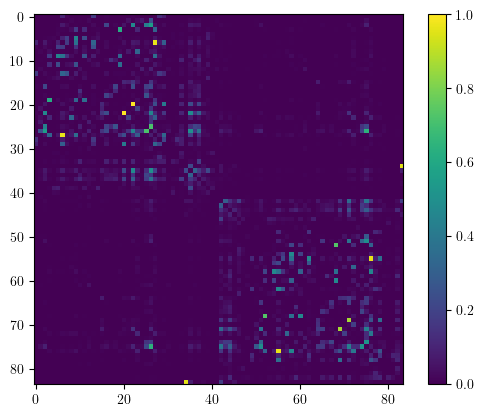

In [15]:
plt.imshow(s_conn.weights)
plt.colorbar()

### Plotting settings:

In [17]:
from matplotlib.colors import ListedColormap

cmap1 = ['darkblue', 'navy', 'mediumblue', 'dodgerblue', 'deepskyblue'][::-1]
cmap2 = [ 'rebeccapurple','purple', 'mediumorchid', 'orchid', 'plum'][::-1]
cmap3 = ['darkred', 'red', 'lightcoral', 'salmon', 'lightsalmon'][::-1]
cmap4 = ['darkgreen', '#005900', '#008C00', '#00BF00', '#00F200'][::-1]

cmaps = [cmap1, cmap2, cmap3]


MOUT : 0.23433536513664857


(84, 84)

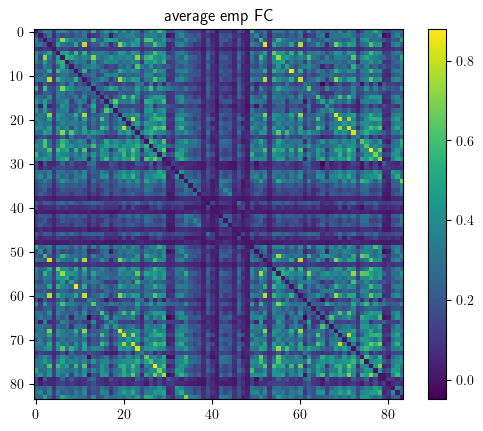

In [18]:
# return (psp, y0_psp,  dist_y0_perc, bold, FRs, gc_value)
fc_data= sio.loadmat('/Users/jansta/fic_jansen/stability_analysis/HCP/avg_FC/avg_FC.mat')
emp_FC = fc_data['avgFC']


plt.title('average emp FC')
print(f'MOUT : {np.mean(prep_FC(emp_FC))}')
plt.imshow(emp_FC)
plt.colorbar()
emp_FC.shape
#fc_data.keys()

### Loading the simulation data:

In [19]:

# return (psp, y0_psp,  dist_y0_perc, bold, FRs, gc_value)
# return (psp, y0_psp, bold, gc_value)

In [20]:

if not load_data:
    print('processing the data')
    res_dict = {}
    for res_file in os.listdir(DATA_LOC):
        if res_file.startswith('post'):
            print(res_file)
            y0_string = res_file.split('_')[5]
            print(y0_string)
            data = np.load(DATA_LOC + res_file, allow_pickle=True)
            res_dict[y0_string] = {}
            for idx, sgc_data in enumerate(data):
                gc = sgc_data[3]
                #print(gc)
                sim_FC = calc_FC(sgc_data[2][10:,0,:,0])
                R_score = np.corrcoef(prep_FC(sim_FC), prep_FC(emp_FC))[0,1]
                res_dict[y0_string][gc] = [np.mean(sgc_data[0][:,:]),get_peak_freq(sgc_data[0][:,:]), np.mean(sgc_data[1][:,:]), sim_FC, R_score]
            res_dict[y0_string] = dict(sorted(res_dict[y0_string].items(), key=lambda x: key_as_number(x[0])))
   
    #print(res_dict)
    res_dict = dict(sorted(res_dict.items(), key=lambda x: key_as_number(x[0])))
    if save_the_data:
        np.save(DATA_LOC + 'processed_postFIC_data.npy', res_dict, allow_pickle=True)

    res_dict_nf = {}
    for res_file in os.listdir(DATA_LOC):
        if res_file.startswith('no_fic'):
            print(res_file)
            y0_string = res_file.split('_')[5]
            print(y0_string)
            res_dict_nf[y0_string] = {}
            data = np.load(DATA_LOC + res_file, allow_pickle=True)
            for idx, sgc_data in enumerate(data):
                gc = sgc_data[3]
                sim_FC = calc_FC(sgc_data[2][10:,0,:,0])
                R_score = np.corrcoef(prep_FC(sim_FC), prep_FC(emp_FC))[0,1]
                print(y0_string, R_score)
                res_dict_nf[y0_string][gc] = [np.mean(sgc_data[0][:,:]), get_peak_freq(sgc_data[0][:,:]), np.mean(sgc_data[1][:,:]), sim_FC, R_score]
            res_dict_nf[y0_string] = dict(sorted(res_dict_nf[y0_string].items(), key=lambda x: key_as_number(x[0])))
                

    res_dict_nf = dict(sorted(res_dict_nf.items(), key=lambda x: key_as_number(x[0])))
    if save_the_data:
        np.save(DATA_LOC + 'processed_noFIC_data.npy', res_dict_nf, allow_pickle=True)
else:
    print('loading processed data from files')
    res_dict = np.load(DATA_LOC + 'processed_postFIC_data.npy', allow_pickle=True).item()
    res_dict_nf  = np.load(DATA_LOC + 'processed_noFIC_data.npy',  allow_pickle=True).item()


loading processed data from files


### extracting data subtypes:

In [22]:
ny0 = len(res_dict.keys()) * 2 
ngc = len(res_dict['0.007'].keys())
 
print(ny0, ngc)

Rs_mat = np.zeros([ny0,ngc])
PSPmean_mat = np.zeros([ny0,ngc])
y0PSPmean_mat = np.zeros([ny0,ngc])
PFmean_mat = np.zeros([ny0,ngc])
#FRmean_mat = np.zeros([ny0,ngc])
MOUT_mat = np.zeros([ny0,ngc])
for ydx, y0t in enumerate(res_dict.keys()):
    for gdx, gc in enumerate(res_dict[y0t].keys()):
            Rs_mat[ydx,gdx] = res_dict[y0t][gc][4]
            PSPmean_mat[ydx,gdx] = np.mean(res_dict[y0t][gc][0])
            y0PSPmean_mat[ydx,gdx] = np.mean(res_dict[y0t][gc][2])
            PFmean_mat[ydx,gdx] = np.mean(res_dict[y0t][gc][1][0])
            #FRmean_mat[ydx,gdx] = np.mean(res_dict[y0t][gc][-1])
            MOUT_mat[ydx,gdx] = np.mean(prep_FC(res_dict[y0t][gc][3]))



for ydx, y0t in enumerate(res_dict_nf.keys()):
    for gdx, gc in enumerate(res_dict_nf[y0t].keys()):
            #print(gdx, ydx , Rs_mat.shape)
            Rs_mat[ydx + len(res_dict.keys()) ,gdx] = res_dict_nf[y0t][gc][4]
            #if y0t == '0.14': print(res_dict_nf[y0t][gc][4])
            PSPmean_mat[ydx + len(res_dict.keys()),gdx] = np.mean(res_dict_nf[y0t][gc][0])
            y0PSPmean_mat[ydx + len(res_dict.keys()),gdx] = np.mean(res_dict_nf[y0t][gc][2])
            PFmean_mat[ydx + len(res_dict.keys()),gdx] = np.mean(res_dict_nf[y0t][gc][1][0])
            MOUT_mat[ydx + len(res_dict.keys()),gdx] = np.mean(prep_FC(res_dict_nf[y0t][gc][3]))
         


print(Rs_mat.shape)
print(PSPmean_mat.shape)
print(y0PSPmean_mat.shape)
print(PFmean_mat.shape)

y0s = [float(y0t) for y0t in res_dict.keys()]
gcs = [int(gc) for gc in res_dict['0.01'].keys()]
print(y0s)
print(gcs)


24 30
(24, 30)
(24, 30)
(24, 30)
(24, 30)
[0.001, 0.004, 0.007, 0.01, 0.013, 0.016, 0.0189, 0.1, 0.11, 0.12, 0.13, 0.14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [23]:
y0_Rs = {}
y0_Rs_nf = {}
y0s = [0.001, 0.004, 0.007, 0.01, 0.013, 0.016, 0.0189, 0.1, 0.11, 0.12, 0.13, 0.14]
y0_Rs = {y0: [] for y0 in y0s}
y0_Rs_nf = {y0: [] for y0 in y0s}

### Plotting FC data and synchrony data:

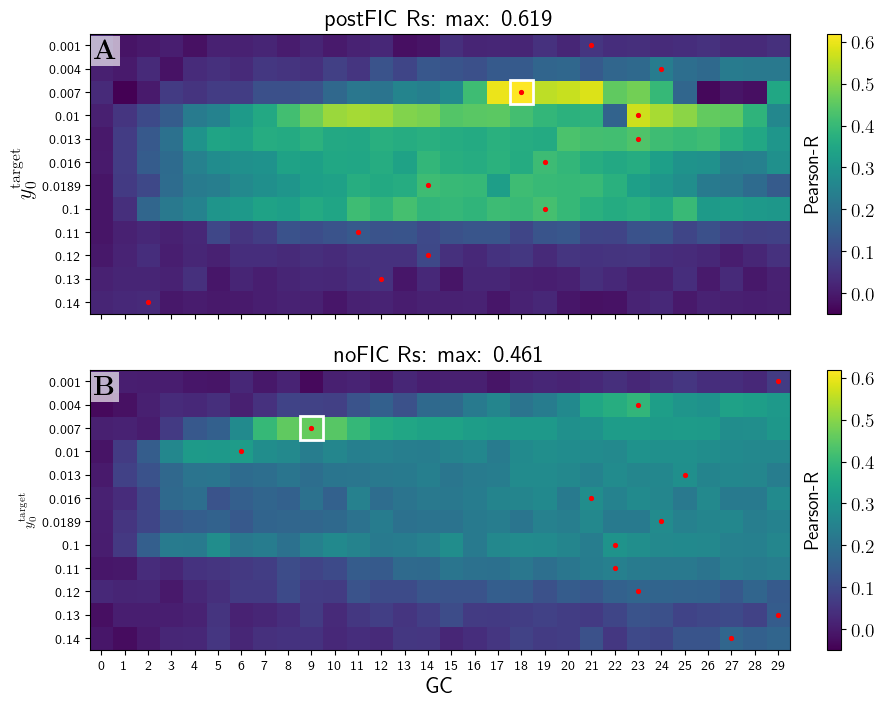

In [24]:
fig_fc, axs = plt.subplots(2, figsize=(12, 8), sharex=True, sharey=True)
dot_idxs = np.zeros([2,12])
vmin = np.min(Rs_mat)
vmax = np.max(Rs_mat)
cmap = 'viridis'
plt.rcParams.update({'font.size': 14})
for idx, ax in enumerate(axs):
    if idx == 0:
        for row_idx in range(Rs_mat[:12,:].shape[0]):
            im = ax.imshow(Rs_mat[:12,:], vmin=vmin, vmax=vmax, cmap=cmap)
            max_value = np.max(Rs_mat[row_idx, :])
            max_col_idx = np.argmax(Rs_mat[row_idx, :])
            ax.scatter(max_col_idx, row_idx, color='red', s=30, marker='.')
            ax.set_yticks(range(12));
            ax.set_yticklabels(y0s)
            ax.set_xticks(range(len(gcs)));
            ax.set_xticklabels(gcs)
            ax.set_ylabel("{\sffamily $y_{0}^{\mathrm{target}}$}%", fontsize=16)
            
            ax.set_title(f'postFIC Rs: max: {np.max(Rs_mat[:12,:]):.3f}')
            y0_Rs[y0s[row_idx]] = max_value
            dot_idxs[idx, row_idx] = max_col_idx
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        max_indices = np.unravel_index(np.argmax(Rs_mat[:12,:]), Rs_mat.shape)

    if idx == 1:
        for row_idx in range(Rs_mat[12:,:].shape[0]):
            im2 = ax.imshow(Rs_mat[12:,:], vmin=vmin, vmax=vmax, cmap=cmap)
            ax.set_ylabel("{\sffamily $y_{0}^{\mathrm{target}}$}%")
            ax.set_xlabel('GC',  fontsize=16)
            max_value= np.max(Rs_mat[row_idx+12, :])
            max_col_idx = np.argmax(Rs_mat[row_idx+12, :])
            ax.scatter(max_col_idx, row_idx, color='red', s=30, marker='.')
            ax.set_title(f'noFIC Rs: max: {np.max(Rs_mat[12:,:]):.3f}')
            ax.set_xlabel('GC',  fontsize=16)
            y0_Rs_nf[y0s[row_idx]] = max_value
            dot_idxs[idx, row_idx] = max_col_idx 
        cbar = plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
        max_indices = np.unravel_index(np.argmax(Rs_mat[12:,:]), Rs_mat.shape)
    max_row, max_col = max_indices
    rect = patches.Rectangle((max_col - 0.5, max_row - 0.5), 1, 1, linewidth=2, edgecolor='white', facecolor='none')
    ax.add_patch(rect)

    
    cbar.set_label('Pearson-R')
    cbar.ax.yaxis.set_label_position('left')
AddPanelLabels(axs, label=PanelsLettersUpper.T, fontsize=20)
if save_the_plots:
    fig_fc.savefig(PLOT_LOC + 'heatmaps_gc_X_y0_Rscores.jpg')


In [53]:
synch_filer = 0.25
filt_mask = MOUT_mat > synch_filer
Rs_mat2 = Rs_mat.copy()
Rs_mat2[filt_mask] = 0
Rs_mat2.shape
np.save(DATA_LOC + 'Rs_mat_thresh.npy', Rs_mat2, allow_pickle=True)

# Rs_mat2 = Rs_mat.copy()
# Rs_mat2 = Rs_mat2 - (0.75 * MOUT_mat)

# Rs_mat2.shape

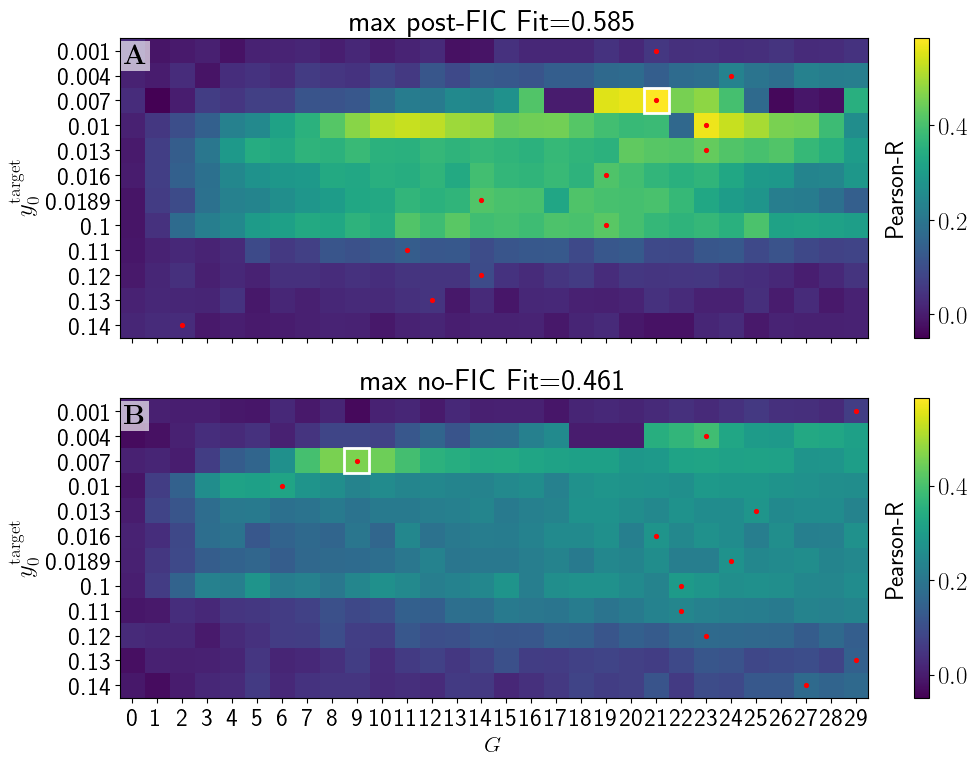

In [55]:
fig_fc, axs = plt.subplots(2, figsize=(12, 8), sharex=True, sharey=True)
dot_idxs = np.zeros([2,12])
vmin = np.min(Rs_mat)
vmax = np.max(Rs_mat2)
#fig_fc.suptitle('vs HCP avg emp FC -filtered')
cmap = 'viridis'

best_d
for idx, ax in enumerate(axs):
    if idx == 0:
        for row_idx in range(Rs_mat2[:12,:].shape[0]):
            im = ax.imshow(Rs_mat2[:12,:], vmin=vmin, vmax=vmax, cmap=cmap)
            max_value = np.max(Rs_mat2[row_idx, :])
            max_col_idx = np.argmax(Rs_mat2[row_idx, :])
            ax.scatter(max_col_idx, row_idx, color='red', s=30, marker='.')
            ax.set_yticks(range(12));
            ax.set_yticklabels(y0s)
            ax.set_xticks(range(len(gcs)));
            ax.set_xticklabels(gcs)
            ax.set_ylabel("{\sffamily $y_{0}^{\mathrm{target}}$}%")
            ax.set_title(f'max post-FIC Fit={np.max(Rs_mat2[:12,:]):.3f}')
            y0_Rs[y0s[row_idx]] = max_value
            dot_idxs[idx, row_idx] = max_col_idx
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        max_indices = np.unravel_index(np.argmax(Rs_mat2[:12,:]), Rs_mat2.shape)

    if idx == 1:
        for row_idx in range(Rs_mat2[12:,:].shape[0]):
            im2 = ax.imshow(Rs_mat2[12:,:], vmin=vmin, vmax=vmax, cmap=cmap)
            max_value= np.max(Rs_mat2[row_idx+12, :])
            max_col_idx = np.argmax(Rs_mat2[row_idx+12, :])
            ax.scatter(max_col_idx, row_idx, color='red', s=30, marker='.')
            ax.set_title(f'max no-FIC Fit={np.max(Rs_mat2[12:,:]):.3f}')
            ax.set_ylabel("{\sffamily $y_{0}^{\mathrm{target}}$}%")
            ax.set_xlabel('$G$',  fontsize=16)
            y0_Rs_nf[y0s[row_idx]] = max_value
            dot_idxs[idx, row_idx] = max_col_idx 
        cbar = plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
        max_indices = np.unravel_index(np.argmax(Rs_mat2[12:,:]), Rs_mat2.shape)
    max_row, max_col = max_indices
    rect = patches.Rectangle((max_col - 0.5, max_row - 0.5), 1, 1, linewidth=2, edgecolor='white', facecolor='none')
    ax.add_patch(rect)

    
    cbar.set_label('Pearson-R')
    cbar.ax.yaxis.set_label_position('left')
AddPanelLabels(axs, label=PanelsLettersUpper.T, fontsize=20)
fig_fc.tight_layout()
#if save_the_plots:
fig_fc.savefig(PLOT_LOC + 'heatmaps_gc_X_y0_Rscores_threshXI.jpg')

plt.rcParams.update({'font.size': 18})

### saving and plotting best fits data:

In [45]:
pgc = [21, 27, 20, 23, 20, 19, 14, 19, 11, 14, 12, 2]
ngc = [29, 23, 9, 5, 25, 21, 24, 22, 22, 23, 29, 27]
best_d = {}
for idx, key in enumerate(y0s):
    best_d[key] = [pgc[idx], ngc[idx]]
best_d

np.save(DATA_LOC + 'best_d_fits.npy', best_d, allow_pickle=True)

In [46]:
print(list(y0_Rs.keys()))
print(list(y0_Rs.values()))
#print(len(list(y0_Rs_nf.values())))

y0_Rs.values()
#dot_idxs

[0.001, 0.004, 0.007, 0.01, 0.013, 0.016, 0.0189, 0.1, 0.11, 0.12, 0.13, 0.14]
[0.053659033007783206, 0.2311273669328732, 0.5845940672917381, 0.5673779205510091, 0.43607921082444734, 0.41024786199470875, 0.4125510979877211, 0.4215103011596669, 0.13873175597303822, 0.095223274783521, 0.04626185940312792, 0.030594230846307635]


dict_values([0.053659033007783206, 0.2311273669328732, 0.5845940672917381, 0.5673779205510091, 0.43607921082444734, 0.41024786199470875, 0.4125510979877211, 0.4215103011596669, 0.13873175597303822, 0.095223274783521, 0.04626185940312792, 0.030594230846307635])

[0.001, 0.004, 0.007, 0.01, 0.013, 0.016, 0.0189]


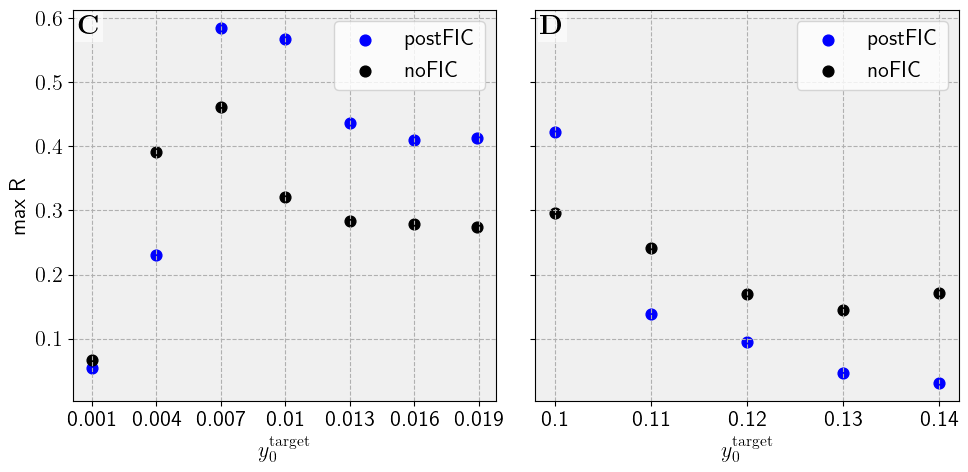

In [48]:
x11 = [i for i in list(y0_Rs.keys()) if i < 0.02]
print(x11)
x12 = [i for i in list(y0_Rs.keys()) if i > 0.09]  # Values in the range 0-0.02
y11 = [y0_Rs[i] for i in list(y0_Rs.keys()) if i < 0.02]
y12 = [y0_Rs[i] for i in list(y0_Rs.keys()) if i > 0.09]
x21 = [i for i in list(y0_Rs_nf.keys()) if i < 0.02]
x22 = [i for i in list(y0_Rs_nf.keys()) if i > 0.09]  # Values in the range 0-0.02
y21 = [ y0_Rs_nf[i]  for i in list(y0_Rs_nf.keys()) if i < 0.02]
y22 = [ y0_Rs_nf[i]  for i in list(y0_Rs_nf.keys()) if i > 0.09]


plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(1,2, figsize=(10,5), sharey=True)
axs[0].scatter(x11 , y11 , color='b', s=60 )
axs[0].scatter(x21 , y21 , color='k', s=60 )

axs[1].scatter(x12 , y12 , color='b', s=60 )
axs[1].scatter(x22 , y22 , color='k', s=60 )

axs[0].set_ylabel('max R')
axs[0].set_xticks([0.001, 0.004, 0.007, 0.01, 0.013, 0.016, 0.019])
axs[0].set_xticklabels([0.001, 0.004, 0.007, 0.01, 0.013, 0.016, 0.019])


axs[1].set_xticks([0.1, 0.11, 0.12, 0.13, 0.14])
axs[1].set_xticklabels([0.1, 0.11, 0.12, 0.13, 0.14])


for ax in axs: 
    ax.grid(ls='--')
    ax.set_xlabel("{\sffamily $y_{0}^{\mathrm{target}}$}%")
    ax.legend(['postFIC', 'noFIC'],loc='upper right')
    ax.set_facecolor('#F0F0F0')
fig.tight_layout()
AddPanelLabels(axs, label=PanelsLettersUpper[2:].T, fontsize=20)

fig.savefig(PLOT_LOC + 'postFIC_vs_noFIC_FC_correlation_score_per_y0t_twoplot_thresh.jpg')


### Synchrony data

###### avg(FC)

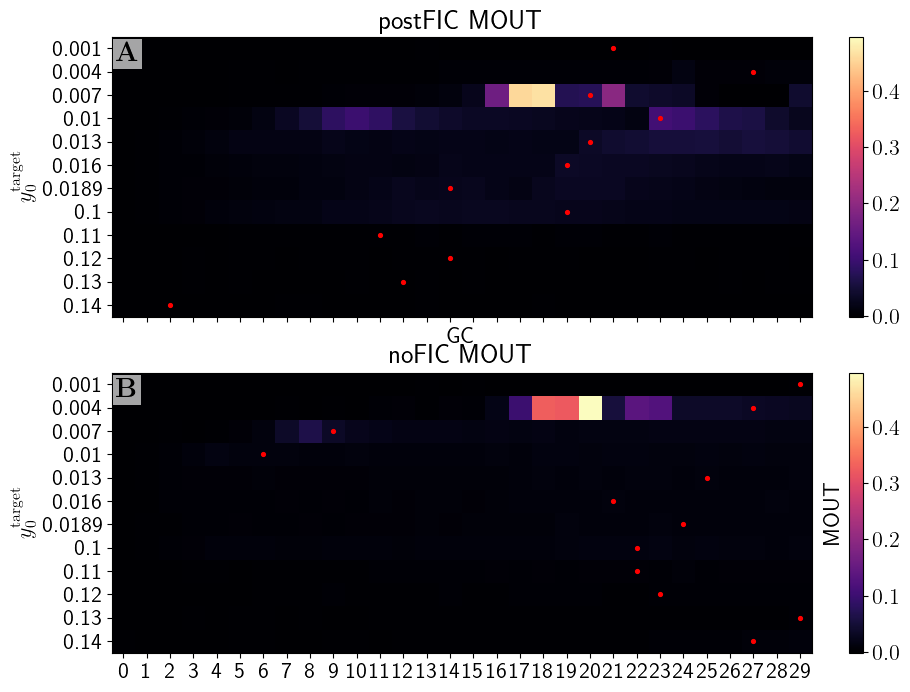

In [70]:
fig, axs = plt.subplots(2, figsize=(12, 8), sharex=True, sharey=True)
vmin = np.min(MOUT_mat)
vmax = np.max(MOUT_mat)
cmap2= 'magma'
for idx, ax in enumerate(axs):
    if idx == 0:
        im = ax.imshow(MOUT_mat[:12,:], vmin=vmin, vmax=vmax, cmap=cmap2)
        ax.set_yticks(range(12));
        ax.set_yticklabels(y0s)
        ax.set_xticks(range(len(gcs)));
        ax.set_xticklabels(gcs)
        ax.set_title(f'postFIC MOUT')
        ax.set_ylabel("{\sffamily $y_{0}^{\mathrm{target}}$}%")
        ax.set_xlabel('GC',  fontsize=16)
        ax.scatter(dot_idxs[idx], range(12), color='red', s=30, marker='.')
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    if idx == 1:
        im2 = ax.imshow(MOUT_mat[12:,:], vmin=vmin, vmax=vmax, cmap=cmap2)
        ax.set_title(f'noFIC MOUT')
        ax.scatter(dot_idxs[idx], range(12), color='red', s=30, marker='.')
        ax.set_ylabel("{\sffamily $y_{0}^{\mathrm{target}}$}%")
        cbar = plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('MOUT')
cbar.ax.yaxis.set_label_position('left')
if save_the_plots:
    fig.savefig(PLOT_LOC + 'heatmap_gc_X_y0_MOUTs.jpg')

AddPanelLabels(axs, label=PanelsLettersUpper.T, fontsize=20)
np.save(DATA_LOC + 'MOUT_matrix.npy', MOUT_mat, allow_pickle=True)

### FC data cd...

Synchrony MOUT:  0.07593803027890965


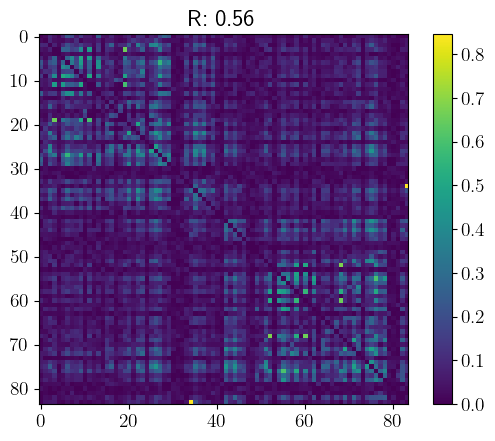

In [25]:
y0 = str(0.007)
gc = str(20)
#plt.title(f'best fitting sim FC with R: {res_dict[y0][gc][4]}')
plt.title(f'R: {res_dict[y0][gc][4]:.2f}')
plt.imshow(np.abs(res_dict[y0][gc][3]))
plt.colorbar()
if save_the_data:
    plt.savefig(PLOT_LOC + f'Best_R_sim_mat_y0_{y0}_gc_{gc}.jpg')
print('Synchrony MOUT: ', MOUT_mat[y0s.index(float(y0)),gcs.index(float(gc))])


Synchrony MOUT:  0.46651404107112054


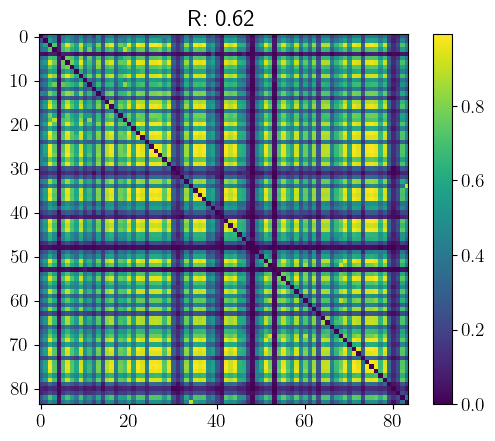

In [26]:
y0 = str(0.007)
gc = str(18)
#plt.title(f' good fitting sim FC with R: {res_dict[y0][gc][4]}')
plt.title(f'R: {res_dict[y0][gc][4]:.2f}')
plt.imshow(np.abs(res_dict[y0][gc][3]), cmap='viridis')
plt.colorbar()
if save_the_data:
    plt.savefig(PLOT_LOC + f'Best_R_sim_mat_y0_{y0}_gc_{gc}OS.jpg')
print('Synchrony MOUT: ', MOUT_mat[y0s.index(float(y0)),gcs.index(float(gc))])

Synchrony MOUT:  0.03507862581036626


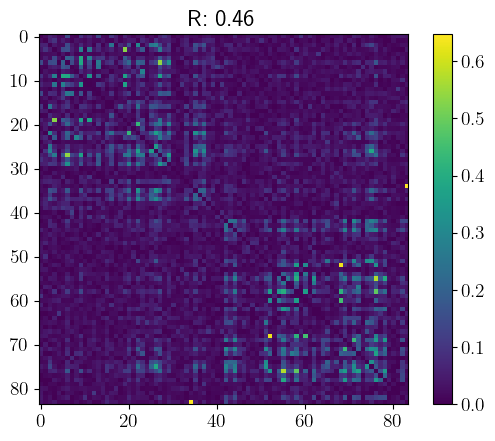

In [27]:
y0 = str(0.007)
gc = str(9)
#plt.title(f'best noFIC fit - sim FC with R: {res_dict_nf[y0][gc][4]}')
plt.title(f'R: {res_dict_nf[y0][gc][4]:.2f}')
plt.imshow(np.abs(res_dict_nf[y0][gc][3]), cmap='viridis')
plt.colorbar()
print('Synchrony MOUT: ', MOUT_mat[y0s.index(float(y0))+12,gcs.index(float(gc))])

Synchrony MOUT:  0.018088012810508005


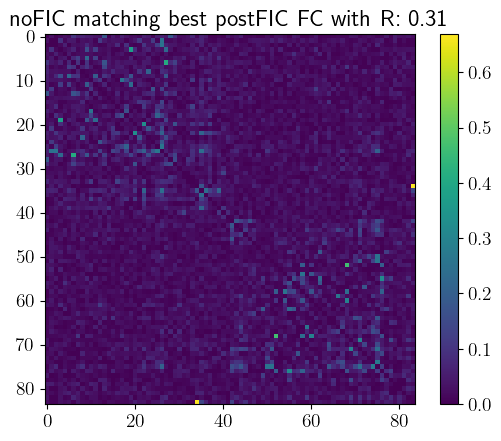

In [28]:
y0 = str(0.007)
gc = str(18)

plt.title(f'noFIC matching best postFIC FC with R: {res_dict_nf[y0][gc][4]:.2f}')
plt.imshow(np.abs(res_dict_nf[y0][gc][3]), cmap='viridis')
plt.colorbar()
print('Synchrony MOUT: ', MOUT_mat[y0s.index(float(y0))+12,gcs.index(float(gc))])

Synchrony MOUT:  0.012405162013005618


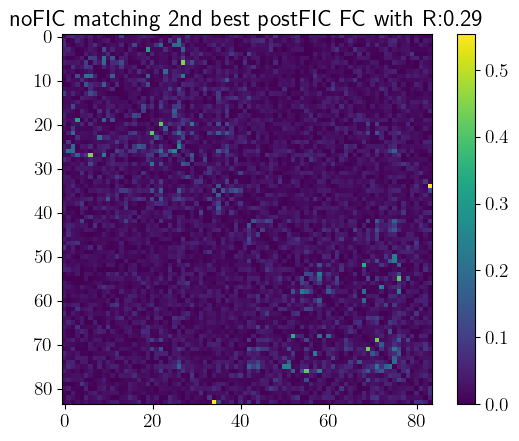

In [29]:
y0 = str(0.01)
gc = str(23)
plt.title(f'noFIC matching 2nd best postFIC FC with R:{res_dict_nf[y0][gc][4]:.2f}')
plt.imshow(np.abs(res_dict_nf[y0][gc][3]), cmap='viridis')
plt.colorbar()
print('Synchrony MOUT: ', MOUT_mat[y0s.index(float(y0))+12,gcs.index(float(gc))])

Synchrony MOUT:  0.00930948349860649


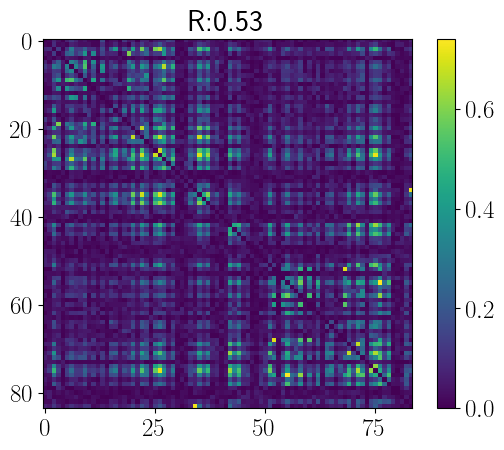

In [51]:
y0 = str(0.01)
gc = str(11)
plt.title(f'R:{res_dict[y0][gc][4]:.2f}')
plt.imshow(np.abs(res_dict[y0][gc][3]), cmap='viridis')
plt.colorbar()
print('Synchrony MOUT: ', MOUT_mat[y0s.index(float(y0))+12,gcs.index(float(gc))])

### Neat FC plot for the paper.

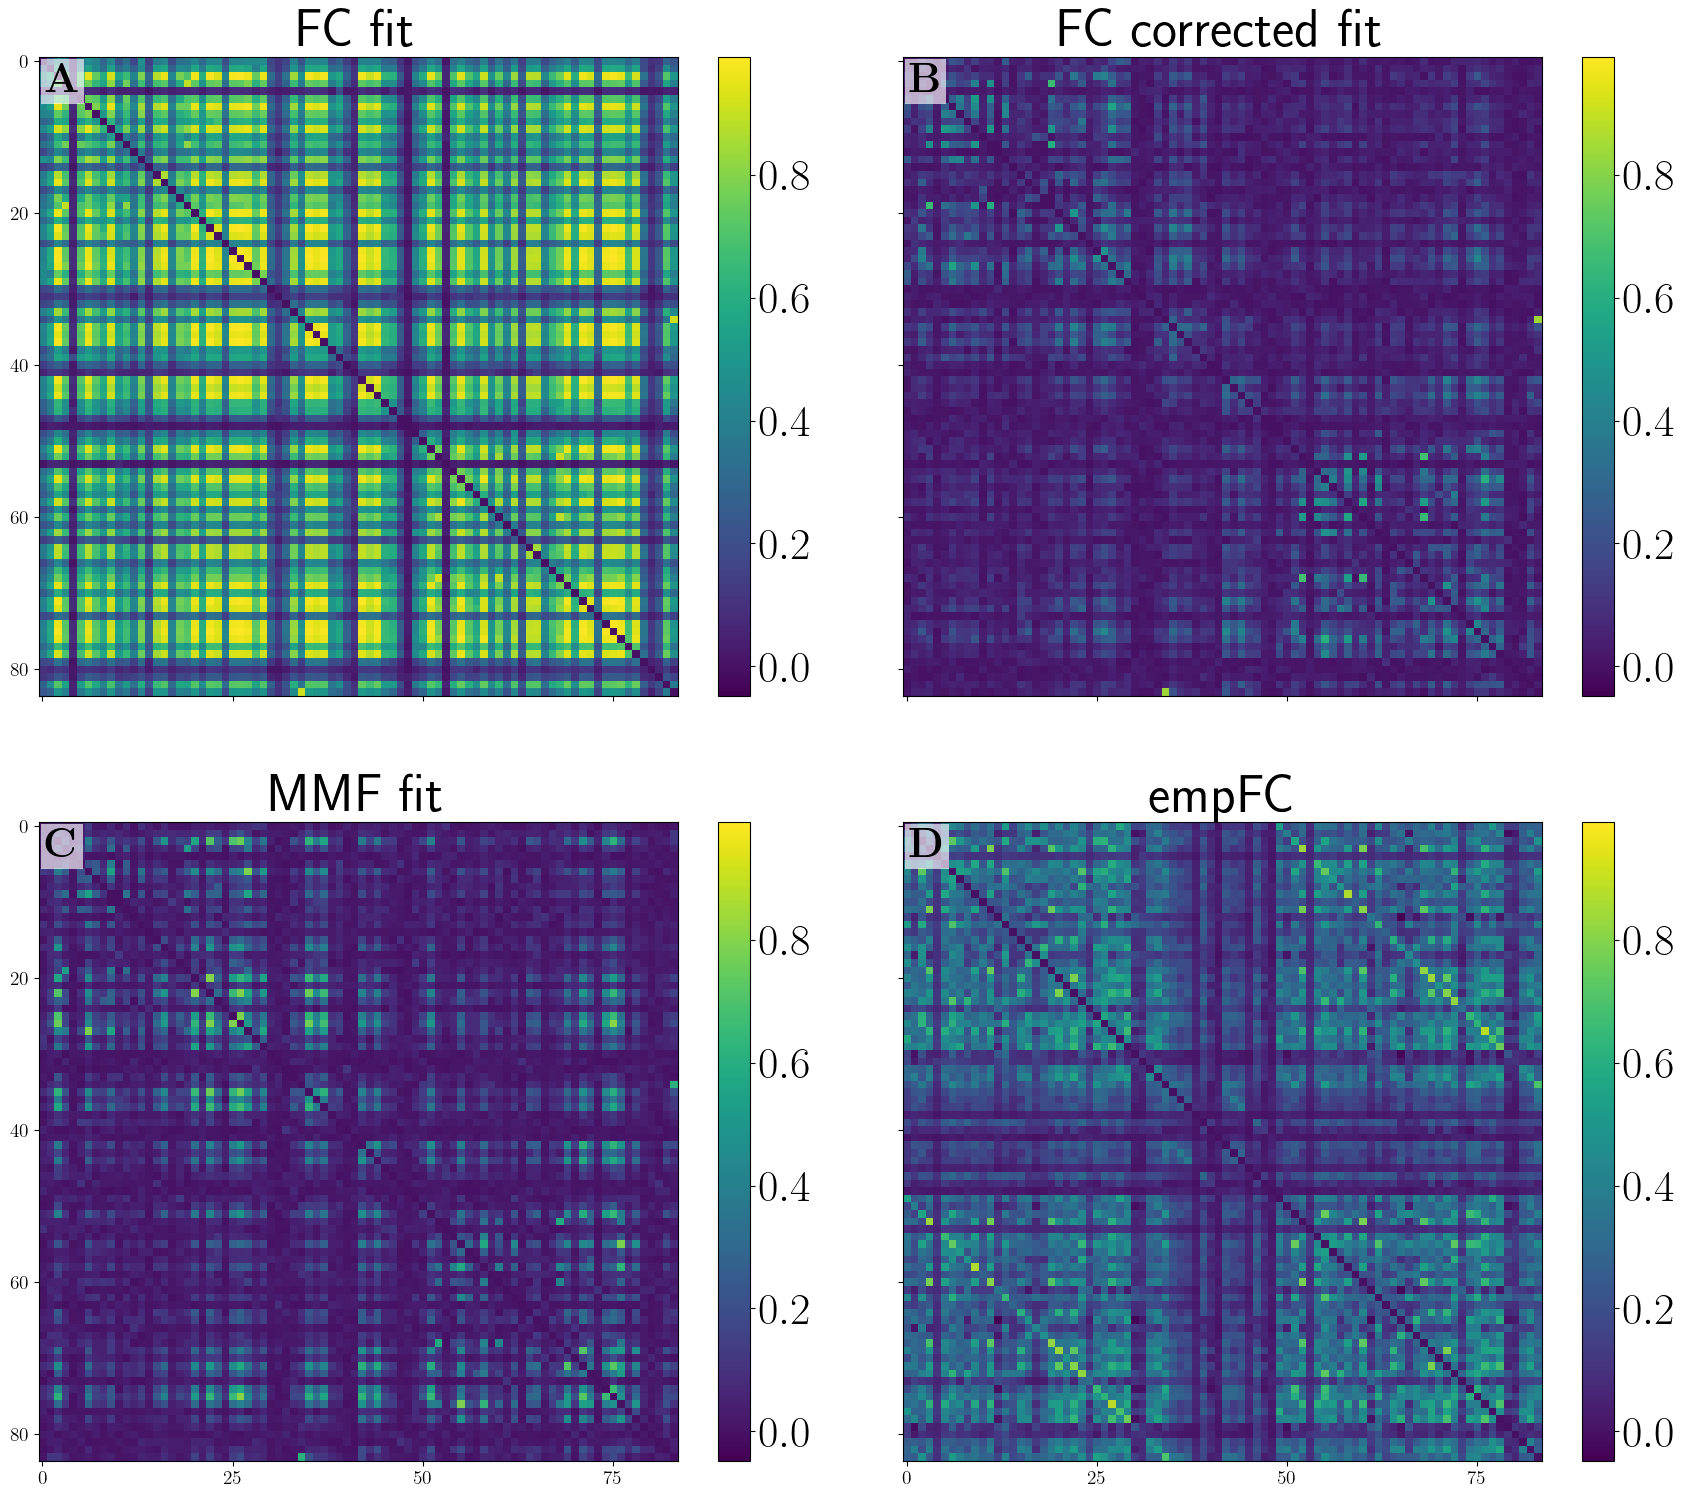

In [30]:
fig, axs = plt.subplots(2,2, figsize=(18, 16), sharex=True, sharey=True)
plt.rcParams.update({'font.size': 32})
m = [np.abs(res_dict[str(0.007)][str(18)][3]),
    np.abs(res_dict[str(0.007)][str(20)][3]),
    np.abs(res_dict[str(0.01)][str(9)][3]), emp_FC]
ts = ['FC fit', 'FC corrected fit', ' MMF fit', 'empFC']
vmin, vmax = np.min(m), np.max(m)

for i, (data, title) in enumerate(zip(m, ts)):
    img = axs.flatten()[i].imshow(data, vmin=vmin, vmax=vmax)
    fig.colorbar(img, ax=axs.flatten()[i], orientation='vertical', shrink=0.89, pad=0.05)
    axs.flatten()[i].set_title(title)
    # axs.flatten()[i].set_xlabel('nodes')
    # axs.flatten()[i].set_ylabel('nodes')
AddPanelLabels(axs, label=PanelsLettersUpper.T, fontsize=30)

fig.tight_layout()
if save_the_plots:
    fig.savefig(PLOT_LOC + 'top_FCs_appendix.png')


### plotting the heatmaops for other data data modalities:
##### mean y0 PSP heatmap

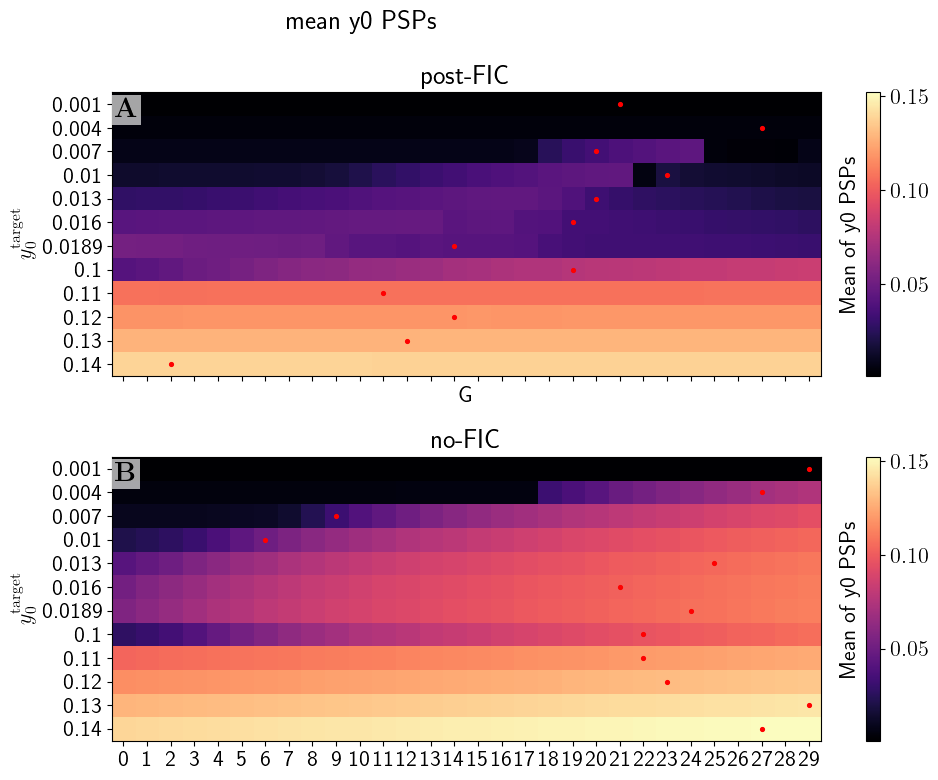

In [83]:
plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(2, figsize=(12, 8), sharex=True, sharey=True)
vmin = np.min(y0PSPmean_mat)
vmax = np.max(y0PSPmean_mat)
fig.suptitle('mean y0 PSPs')
cmap = 'magma'
for idx, ax in enumerate(axs):
    if idx == 0:

        im = ax.imshow(y0PSPmean_mat[:12,:], vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_yticks(range(12));
        ax.set_yticklabels(y0s)
        ax.set_xticks(range(len(gcs)));
        ax.set_xticklabels(gcs)
        ax.set_title(f'post-FIC')
        ax.set_ylabel("{\sffamily $y_{0}^{\mathrm{target}}$}%")
        ax.set_xlabel('G',  fontsize=16)
        ax.scatter(dot_idxs[idx], range(12), color='red', s=30, marker='.')

    if idx == 1:
        ax.imshow(y0PSPmean_mat[12:,:], vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(f'no-FIC ')
        ax.set_ylabel("{\sffamily $y_{0}^{\mathrm{target}}$}%")
       
        ax.scatter(dot_idxs[idx], range(12), color='red', s=30, marker='.')
    
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Mean of y0 PSPs')
    cbar.ax.yaxis.set_label_position('left')
fig.tight_layout()   
AddPanelLabels(axs, label=PanelsLettersUpper.T, fontsize=20)
if save_the_plots:
    fig.savefig(PLOT_LOC + 'heatmap_gc_X_y0_meanPSPs.jpg')

##### peak frequency

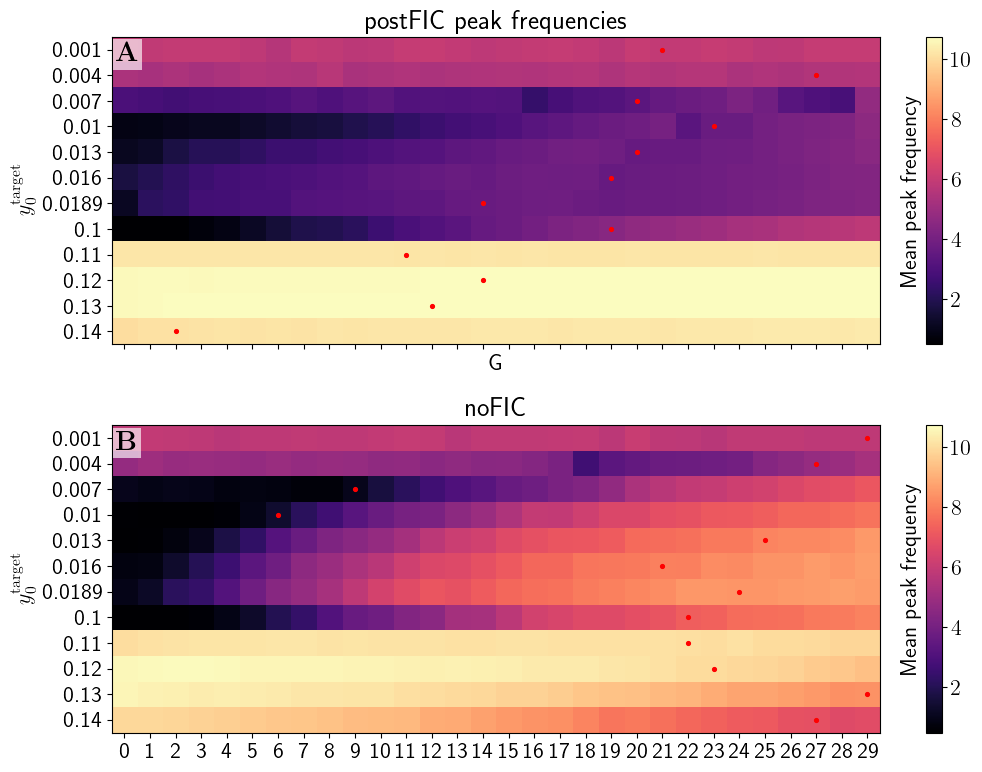

In [84]:
fig, axs = plt.subplots(2, figsize=(12, 8), sharex=True, sharey=True)
vmin = np.min(PFmean_mat)
vmax = np.max(PFmean_mat)
cmap = 'magma'
for idx, ax in enumerate(axs):
    if idx == 0:
        im = ax.imshow(PFmean_mat[:12,:], vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_ylabel(f"{lat_y0t}")
        ax.set_xlabel('G',  fontsize=16)
        ax.set_yticks(range(12));
        ax.set_yticklabels(y0s)
        ax.set_xticks(range(len(gcs)));
        ax.set_xticklabels(gcs)
        ax.set_title(f'postFIC peak frequencies')
        ax.scatter(dot_idxs[idx], range(12), color='red', s=30, marker='.')
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    if idx == 1:
        im2 =ax.imshow(PFmean_mat[12:,:], vmin=vmin, vmax=vmax, cmap=cmap)
        ax.set_title(f'noFIC ')
        ax.set_ylabel(f"{lat_y0t}")
        ax.scatter(dot_idxs[idx], range(12), color='red', s=30, marker='.')
        cbar = plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
        
    cbar.set_label('Mean peak frequency')
    cbar.ax.yaxis.set_label_position('left')
AddPanelLabels(axs, label=PanelsLettersUpper.T, fontsize=20)
fig.tight_layout()
if save_the_plots:
    fig.savefig(PLOT_LOC + 'heatmap_gc_X_y0_meanPF.jpg')

### PlOTTING BEST FITTING SIMULATIONS POST-FIC vs NO-FIC

In [31]:
post1 = next(sgc_data for sgc_data in np.load(DATA_LOC + 'post_fic_results_stability_HCP_0.007_072.npy', allow_pickle=True) if int(sgc_data[3]) == 20)
#post2 = next(sgc_data for sgc_data in np.load(DATA_LOC + 'post_fic_results_stability_HCP_0.01_072.npy', allow_pickle=True) if int(sgc_data[3]) == 23)
post3 = next(sgc_data for sgc_data in np.load(DATA_LOC + 'post_fic_results_stability_HCP_0.1_072.npy', allow_pickle=True) if int(sgc_data[3]) == 19)

In [32]:
nof1 = next(sgc_data for sgc_data in np.load(DATA_LOC + 'no_fic_sim_results_HCP_0.007_072.npy', allow_pickle=True) if int(sgc_data[3]) == 9)
#nof2 = next(sgc_data for sgc_data in np.load(DATA_LOC + 'no_fic_sim_results_HCP_0.004_072.npy', allow_pickle=True) if int(sgc_data[3]) ==  22)
nof3 = next(sgc_data for sgc_data in np.load(DATA_LOC + 'no_fic_sim_results_HCP_0.1_072.npy', allow_pickle=True) if int(sgc_data[3]) ==  22)

In [33]:
mnof1 = next(sgc_data for sgc_data in np.load(DATA_LOC + 'no_fic_sim_results_HCP_0.007_072.npy', allow_pickle=True) if int(sgc_data[3]) == 20)
#mnof2 = next(sgc_data for sgc_data in np.load(DATA_LOC + 'no_fic_sim_results_HCP_0.01_072.npy', allow_pickle=True) if int(sgc_data[3]) == 23)
mnof3 = next(sgc_data for sgc_data in np.load(DATA_LOC + 'no_fic_sim_results_HCP_0.1_072.npy', allow_pickle=True) if int(sgc_data[3]) == 10)

In [37]:
plt.rcParams.update({'font.size': 16})

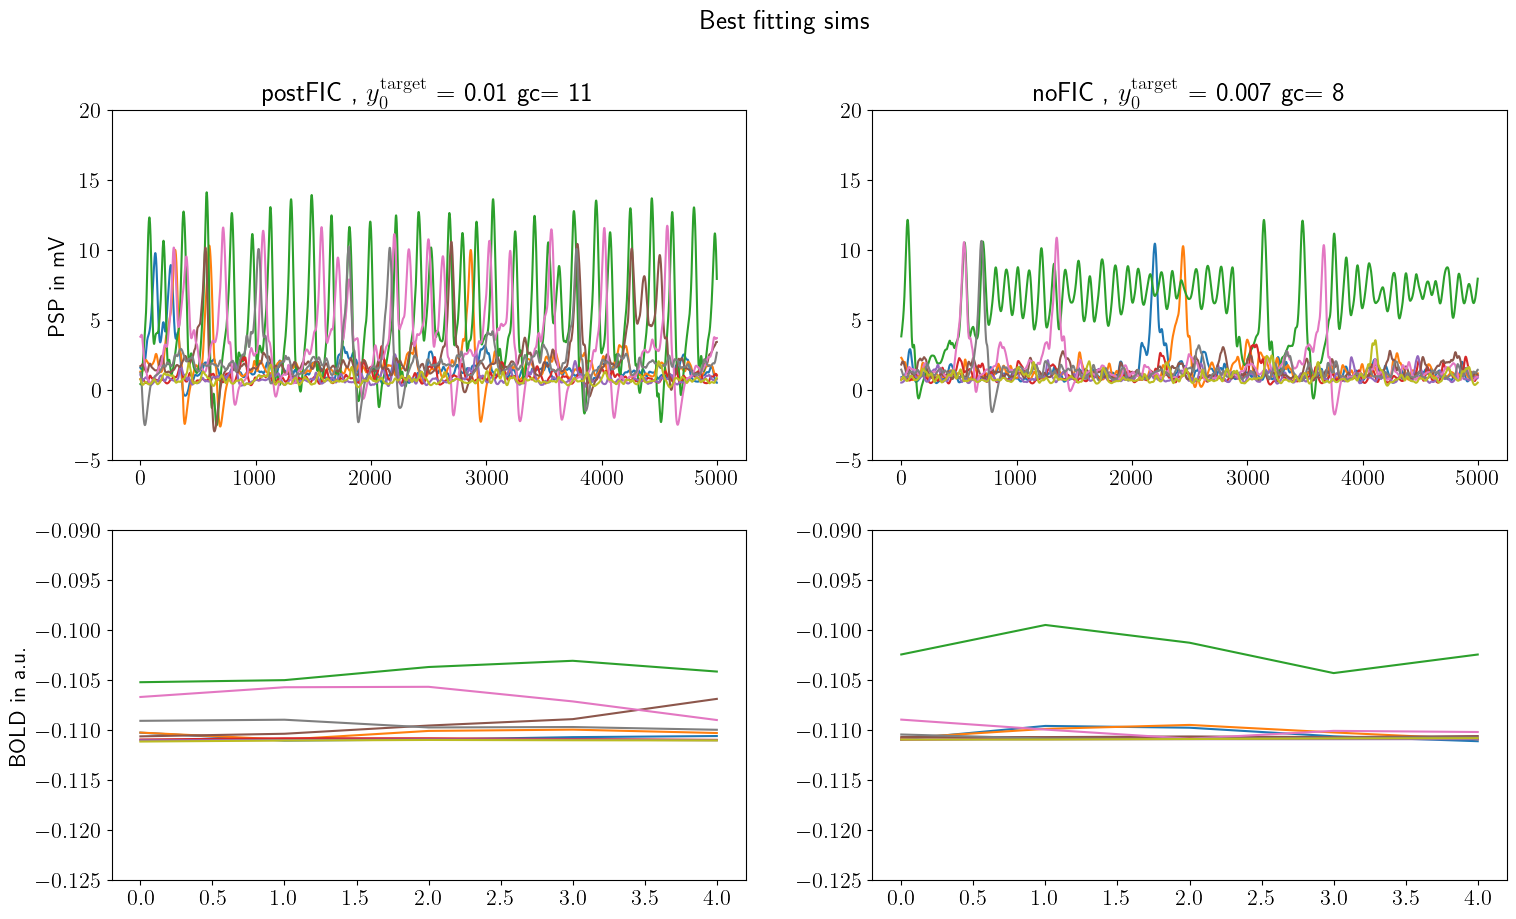

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(18,10))
fig.suptitle('Best fitting sims')
axs[0,0].plot(post1[0][-5000:,::10]);
axs[0,0].set_ylabel('PSP in mV')
axs[0,0].set_title('postFIC , {\sffamily $y_{0}^{\mathrm{target}}$} = 0.01 gc= 11')
axs[0,0].set_ylim(-5, 20)
axs[1,0].set_ylim(-0.125, -0.09)

axs[0,1].plot(nof1[0][-5000:,::10]);
axs[0,1].set_title('noFIC , {\sffamily $y_{0}^{\mathrm{target}}$} = 0.007 gc= 8')
axs[1,0].plot(post1[2][-5:,0,::10,0]);
axs[1,0].set_ylabel('BOLD in a.u.')
axs[1,1].plot(nof1[2][-5:,0,::10,0]);
axs[0,1].set_ylim(-5, 20)
axs[1,1].set_ylim(-0.125, -0.09)
if save_the_plots:
    fig.savefig(PLOT_LOC + 'time-series-plot_best.jpg')


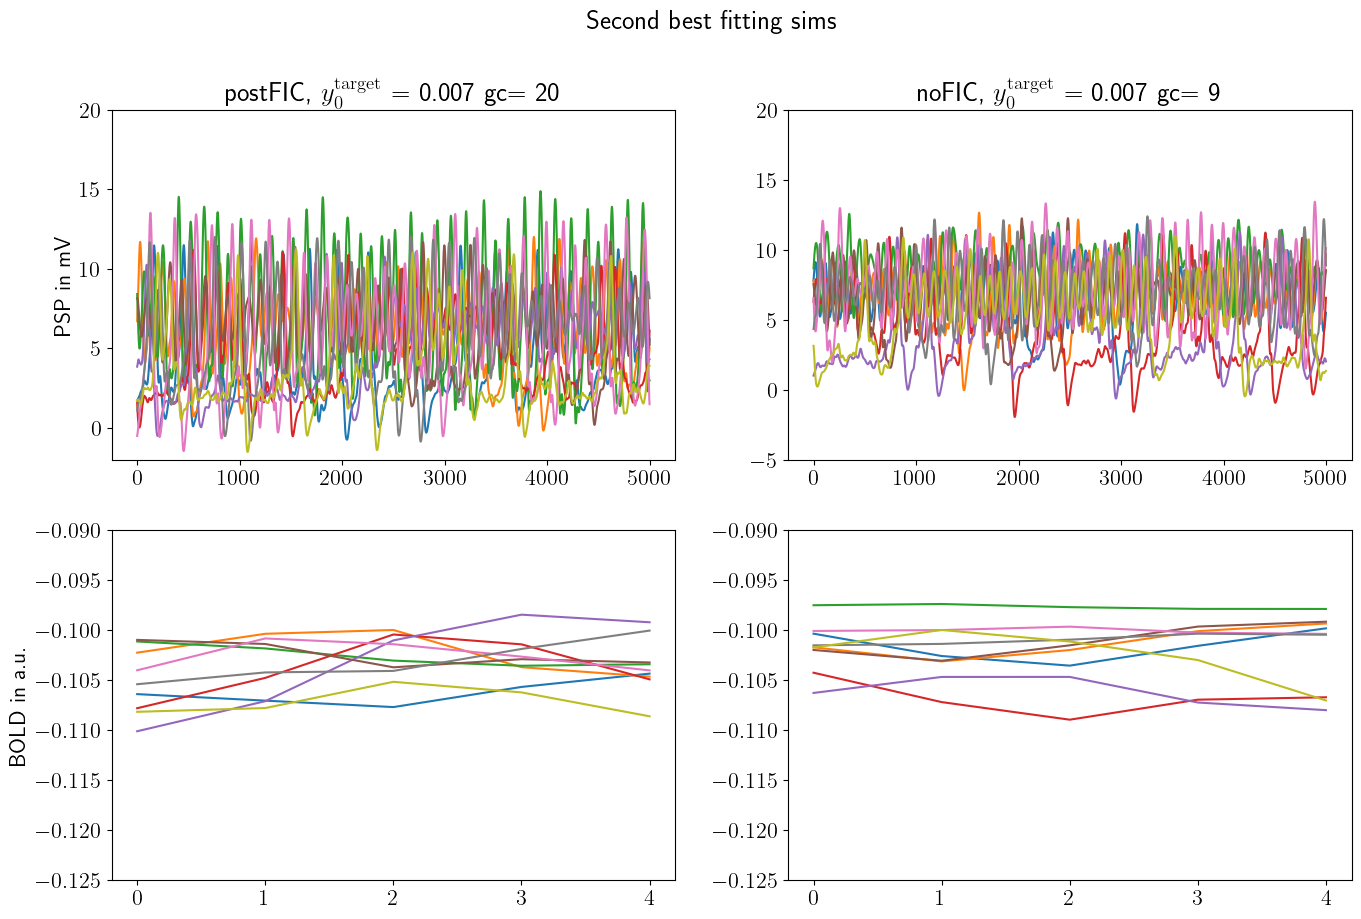

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(16,10))
fig.suptitle('Second best fitting sims')
axs[0,0].plot(post3[0][-5000:,::10]);
axs[0,0].set_ylabel('PSP in mV')
axs[0,0].set_title(f'postFIC, {lat_y0t} = 0.007 gc= 20')
axs[0,1].plot(nof3[0][-5000:,::10]);
axs[0,0].set_ylim(-2, 20)
axs[1,0].set_ylim(-0.125, -0.09)
axs[0,1].set_title(f'noFIC, {lat_y0t} = 0.007 gc= 9')
axs[1,0].plot(post3[2][-5:,0,::10,0]);
axs[1,0].set_ylabel('BOLD in a.u.')
axs[0,1].set_ylim(-5, 20)
axs[1,1].plot(nof3[2][-5:,0,::10,0]);
axs[1,1].set_ylim(-0.125, -0.09)
if save_the_plots:
    fig.savefig(PLOT_LOC + 'time-series-plot_2ndbest.jpg')

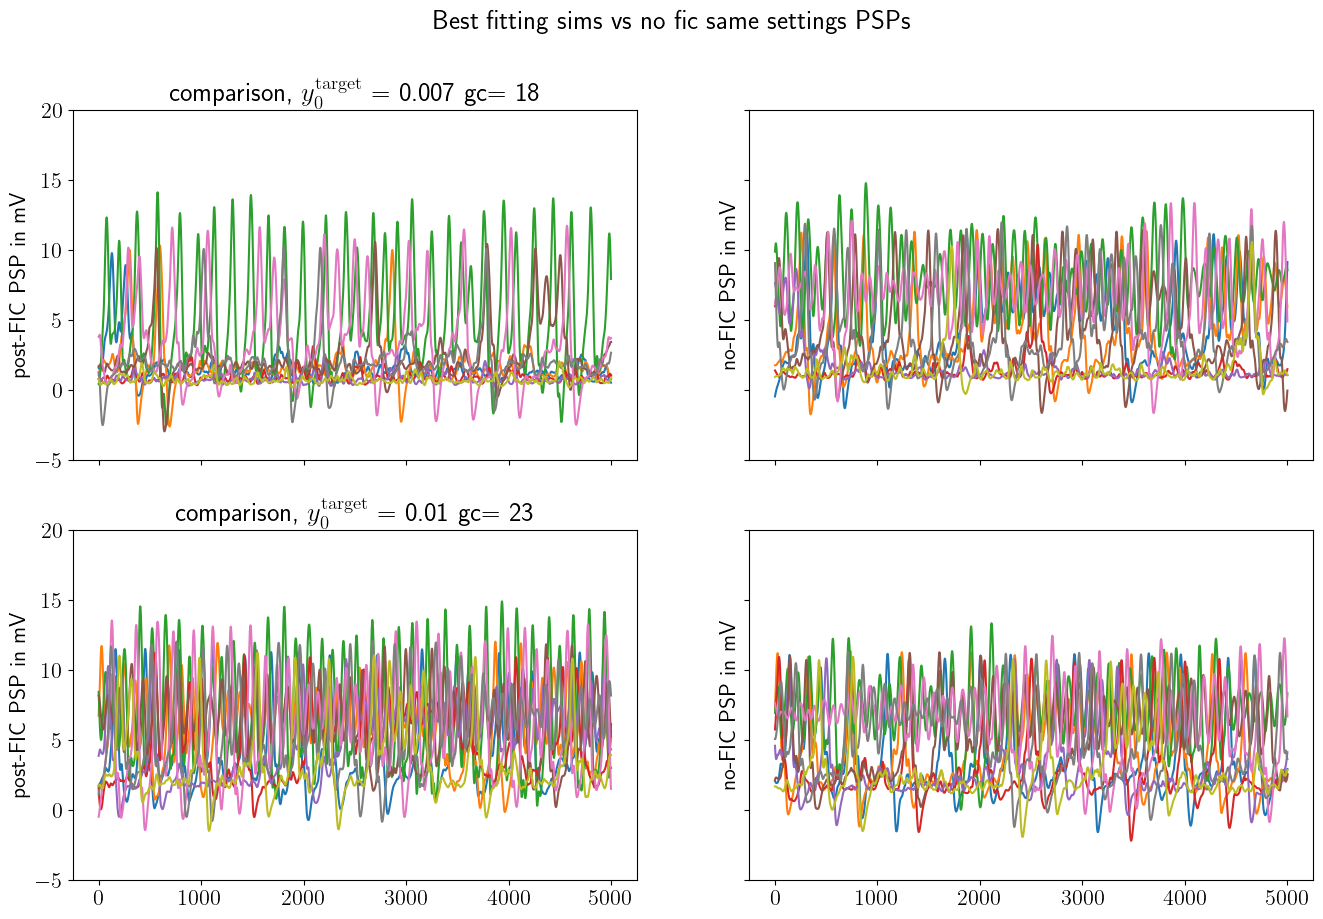

In [40]:
fig, axs = plt.subplots(2, 2, figsize=(16,10), sharex=True, sharey=True)
fig.suptitle('Best fitting sims vs no fic same settings PSPs')
axs[0,0].plot(post1[0][-5000:,::10]);
axs[0,0].set_ylabel('post-FIC PSP in mV')
axs[0,1].set_ylabel('no-FIC PSP in mV')
axs[0,0].set_title('comparison, {\sffamily $y_{0}^{\mathrm{target}}$} = 0.007 gc= 18')
axs[0,1].plot(mnof1[0][-5000:,::10]);
axs[0,0].set_ylim(-5, 20)
axs[1,0].set_title('comparison, {\sffamily $y_{0}^{\mathrm{target}}$} = 0.01 gc= 23')
axs[1,0].plot(post3[0][-5000:,::10]);
axs[1,0].set_ylabel('post-FIC PSP in mV')
axs[1,1].set_ylabel('no-FIC PSP in mV')
axs[1,1].plot(mnof3[0][-5000:,::10]);
if save_the_plots:
    fig.savefig(PLOT_LOC + 'time-series-plot_corr_best.jpg')

### PSD PLOTS  - function definition

In [42]:

def get_peak_freq(PSP, sampling_freq=1000, nperseg=2048):
    # Calculate peak frequency using Welch's method
    psp_f, psp_pxx = signal.welch(PSP, fs=sampling_freq, nperseg=nperseg, axis=0, scaling='density')
    psp_f = psp_f[:50]
    psp_pxx = psp_pxx[:50]
    psp_peak_freq = psp_f[np.argmax(psp_pxx, axis=0)]
    return psp_peak_freq, (psp_f, psp_pxx)

def plot_psds(post_ficPSPs, no_ficPSPs, mno_ficPSPs,  cm, cm2, save_the_plots=False, nplots=2, desc=''):
    fig, axs = plt.subplots(nplots, 1, figsize=(9,12), sharex=True, sharey=True)
    for midx, mod in enumerate([post_ficPSPs, no_ficPSPs, mno_ficPSPs]):
        for idx, psp in enumerate(mod):
            psp_peak_freq, (psp_f, psp_pxx) = get_peak_freq(psp[0][50000:,:])
            if midx == 0:
                axs[idx].plot(psp_f, psp_pxx, color=cm[idx], alpha=0.75)
            if midx == 1:
                axs[idx].plot(psp_f, psp_pxx, color=cm2[idx],linestyle='dashdot', alpha=0.85)
            if midx == 2: 
                axs[idx].plot(psp_f, psp_pxx, color='k', linestyle='dashed', alpha=0.15)
            titles = [f'best FC fit {lat_y0t}=0.007', f'best FC fit {lat_y0t}=0.1']

            axs[idx].set_title(titles[idx])

            if idx == 1:
                
                axs[idx].set_xlabel('freq in Hz')

            axs[idx].set_ylabel('Power')
            legend_elements = [
                Line2D([0], [0], marker='s',color='none', markerfacecolor=cm[idx], markersize=12, markeredgewidth=0.1,label='post-FIC'),
                Line2D([0], [0], marker='s',color='none', markerfacecolor=cm2[idx], markersize=12,markeredgewidth=0.1, label='no-FIC'),
                Line2D([0], [0], marker='s',color='none', markerfacecolor='black', markersize=12,markeredgewidth=0.1, label='match-no-FIC')]
            axs[idx].legend(handles=legend_elements, loc='best')
    AddPanelLabels(axs, label=PanelsLettersUpper.T, fontsize=20)
    fig.tight_layout()
    if save_the_plots:
        fig.savefig(PLOT_LOC + f'Power_spectra_for_{desc}.jpg')

(5,)
(5,)
(5,)
(5,)
(5,)
(5,)


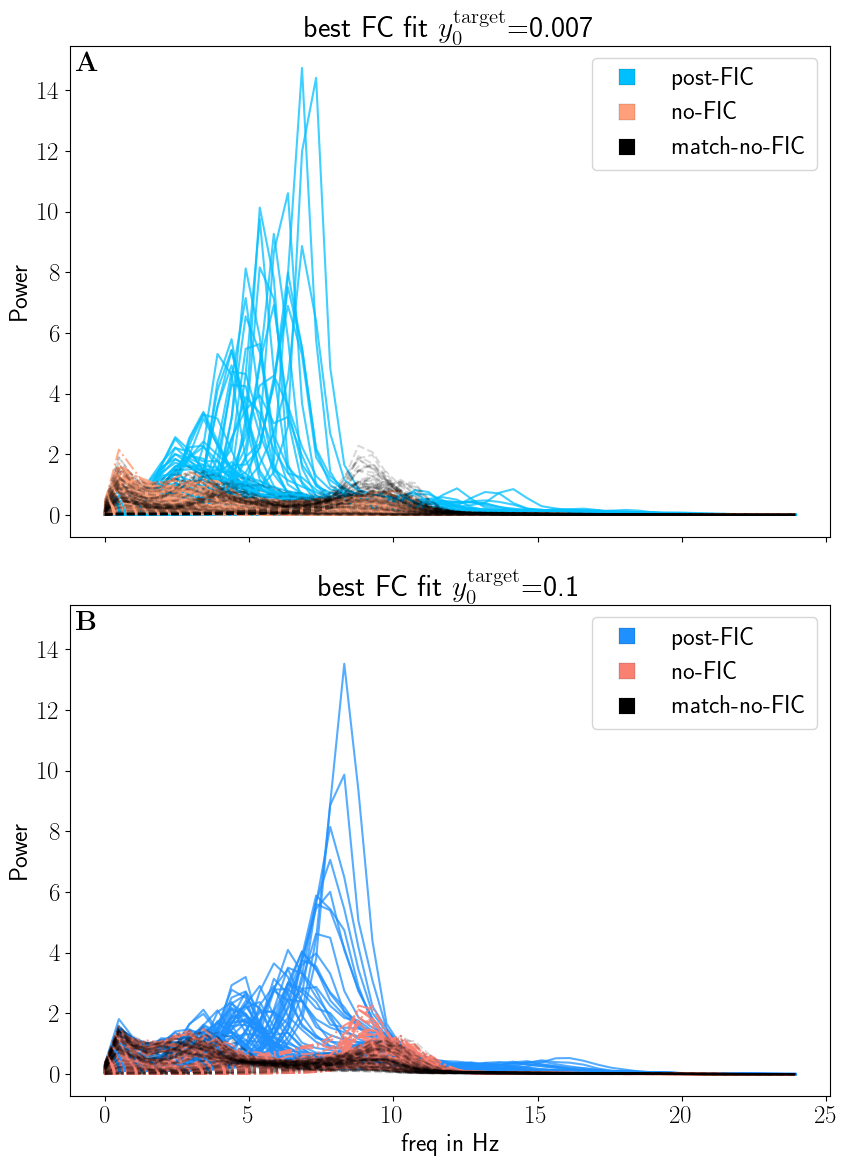

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
plot_psds([post1, post3],[ nof1, nof3],[ mnof1, mnof3],  cmap1, cmap3, save_the_plots=False, nplots=2, desc='best_fits_FC')